# Trabajo Práctico 1: Métricas custom para reducción de falsos positivos en clasificación binaria fraude

**Mark Albrand - 21004**

Función a optimizar:

*Detectar fraudes en regiones con alta incidencia histórica*


In [21]:
# Variables creadas durante el feature engineering

feature_engineering = [
    "fraud_rate_by_zip",
    "fraud_rate_by_city",
    "fraud_rate_by_state",
    "city_fraud_count",

    "monthly_zip_fraud_rate",
    "rolling_fraud_rate_by_zip",

    "region_density",

    "high_risk_region",
]

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# dataset con las nuevas features
dataset = pd.read_csv("data/dataset.csv", index_col=0)

In [24]:
for c in dataset.columns:
    print(c)

cc_num
merchant
category
amt
first
last
gender
street
city
state
zip
lat
long
city_pop
job
dob
trans_num
unix_time
merch_lat
merch_long
is_fraud
amt_month
amt_year
amt_month_shopping_net_spend
count_month_shopping_net
first_time_at_merchant
dist_between_client_and_merch
trans_month
trans_day
hour
year
times_shopped_at_merchant
times_shopped_at_merchant_year
times_shopped_at_merchant_month
times_shopped_at_merchant_day
fraud_rate_by_zip
fraud_rate_by_city
fraud_rate_by_state
city_fraud_count
monthly_zip_fraud_rate
rolling_fraud_rate_by_zip
lat_bin
long_bin
region_density


## Modelo Base

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
drop_cols = [
    'cc_num',
    'first',
    'last',
    'street',
    'trans_num',
    'dob',
]

In [27]:
dataset = dataset.drop(columns=drop_cols, errors='ignore')

In [28]:
from sklearn.preprocessing import LabelEncoder

In [29]:
# usar LabelEncoder para convertir las variables categóricas a numéricas
label_encoder = LabelEncoder()

In [30]:
categorical_cols = dataset.select_dtypes(include=['object']).columns

for col in categorical_cols:
    dataset[col] = label_encoder.fit_transform(dataset[col])

In [31]:
dataset["first_time_at_merchant"] = dataset["first_time_at_merchant"].astype(int)  # Booleano -> int

*Detectar fraudes en regiones con alta incidencia histórica*

Como la función a optimizar es esta, se definirá como "high_risk_region" una variable binaria que indica si la tasa de fraude en la región es mayor al percentil 90 de la tasa de fraude por código postal.

In [32]:
threshold = dataset["fraud_rate_by_zip"].quantile(0.90)
dataset["high_risk_region"] = (dataset["fraud_rate_by_zip"] >= threshold).astype(int)

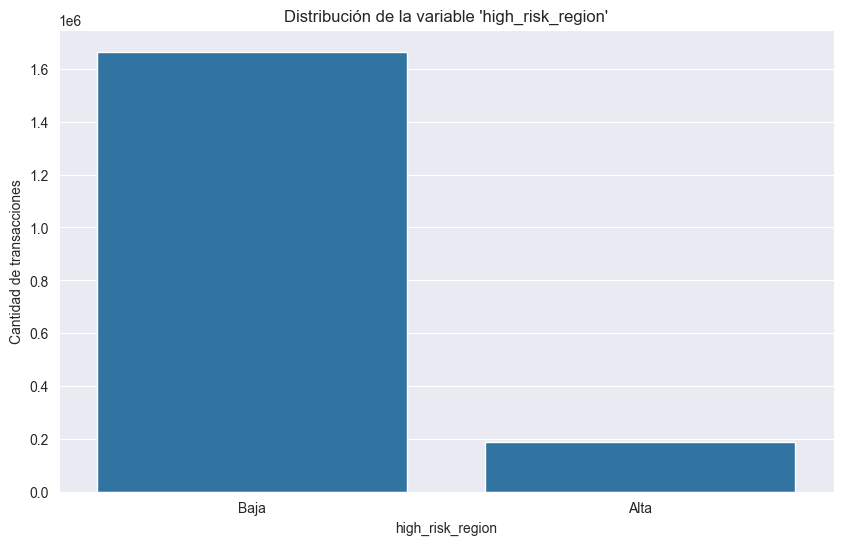

In [33]:
plt.figure(figsize=(10, 6))
sns.countplot(x="high_risk_region", data=dataset)
plt.title("Distribución de la variable 'high_risk_region'")
plt.xlabel("high_risk_region")
plt.ylabel("Cantidad de transacciones")
plt.xticks([0, 1], ["Baja", "Alta"])
plt.show()

### Separar variables predictoras y variable objetivo

In [34]:
X = dataset.drop(columns=["is_fraud"])
y = dataset["is_fraud"]

In [35]:
X.head()

,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,...,fraud_rate_by_zip,fraud_rate_by_city,fraud_rate_by_state,city_fraud_count,monthly_zip_fraud_rate,rolling_fraud_rate_by_zip,lat_bin,long_bin,region_density,high_risk_region
1514,398,7,48.43,0,753,19,1257,42.1001,-73.3611,2121,...,0.003079,0.003079,0.004954,9,0.0,0.0,19,19,18308,0
2491,351,8,1.58,0,753,19,1257,42.1001,-73.3611,2121,...,0.003079,0.003079,0.004954,9,0.0,0.0,19,19,18308,0
4762,174,11,6.10,0,753,19,1257,42.1001,-73.3611,2121,...,0.003079,0.003079,0.004954,9,0.0,0.0,19,19,18308,0
6043,492,6,8.42,0,753,19,1257,42.1001,-73.3611,2121,...,0.003079,0.003079,0.004954,9,0.0,0.0,19,19,18308,0
6499,273,2,31.53,0,753,19,1257,42.1001,-73.3611,2121,...,0.003079,0.003079,0.004954,9,0.0,0.0,19,19,18308,0


In [36]:
y.head()

1514    0
2491    0
4762    0
6043    0
6499    0
Name: is_fraud, dtype: int64

In [37]:
X_train = X[X["unix_time"] < X["unix_time"].quantile(0.75)]
X_test = X[X["unix_time"] >= X["unix_time"].quantile(0.75)]
y_train = y[X["unix_time"] < X["unix_time"].quantile(0.75)]
y_test = y[X["unix_time"] >= X["unix_time"].quantile(0.75)]

In [40]:
print(f"Dataset {pd.to_datetime(X['unix_time'].min(), unit='s')} - {pd.to_datetime(X['unix_time'].max(), unit='s')}")
print(f"Train {pd.to_datetime(X_train['unix_time'].min(), unit='s')} - {pd.to_datetime(X_train['unix_time'].max(), unit='s')}")
print(f"Test {pd.to_datetime(X_test['unix_time'].min(), unit='s')} - {pd.to_datetime(X_test['unix_time'].max(), unit='s')}")

Dataset 2012-01-01 00:00:18 - 2013-12-31 23:59:34
Train 2012-01-01 00:00:18 - 2013-07-23 12:09:59
Test 2013-07-23 12:11:54 - 2013-12-31 23:59:34


In [46]:
X_train_base = X_train.drop(columns=feature_engineering)
X_test_base = X_test.drop(columns=feature_engineering)
y_train_base = y_train
y_test_base = y_test

## Modelo inicial

In [47]:
from lightgbm import LGBMClassifier

In [48]:
model = LGBMClassifier(
    objective="binary",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

In [49]:
model.fit(
    X_train_base, y_train_base,
)

[LightGBM] [Info] Number of positive: 7891, number of negative: 1381404
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 1389295, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', n_jobs=-1, objective='binary',
               random_state=42)

### Evaluación del modelo inicial

In [50]:
from sklearn.metrics import roc_auc_score, f1_score, classification_report

In [51]:
# Predicciones
y_pred = model.predict(X_test_base)
y_proba = model.predict_proba(X_test_base)[:, 1]

In [52]:
# Métricas
roc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

In [53]:
print("AUC-ROC:", roc)
print("F1-Score:", f1)
print(classification_report(y_test, y_pred, digits=4))

AUC-ROC: 0.997454382539442
F1-Score: 0.4109321620302587
              precision    recall  f1-score   support

           0     0.9998    0.9897    0.9947    461339
           1     0.2617    0.9568    0.4109      1760

    accuracy                         0.9896    463099
   macro avg     0.6307    0.9733    0.7028    463099
weighted avg     0.9970    0.9896    0.9925    463099



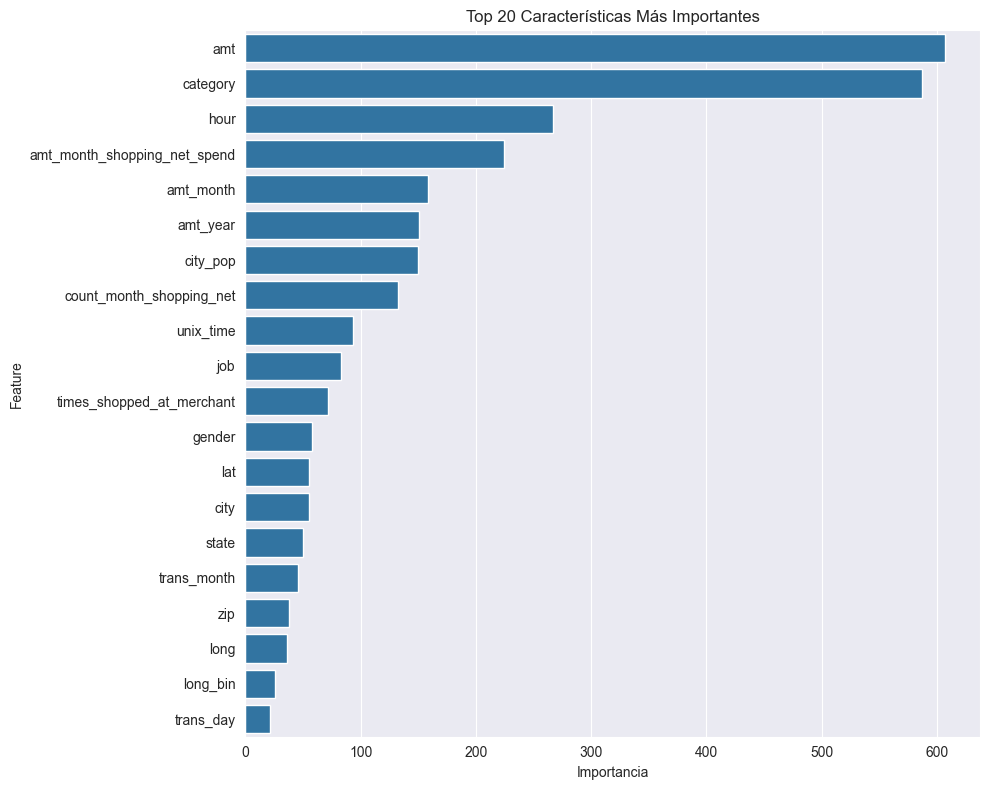

In [55]:
feature_imp = pd.Series(model.feature_importances_, index=X_train_base.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_imp.head(20), y=feature_imp.head(20).index)
plt.title("Top 20 Características Más Importantes")
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [57]:
# guardar modelo
import joblib
import os

if not os.path.exists("models"):
    os.makedirs("models")

if not os.path.exists("models/base"):
    os.makedirs("models/base")

joblib.dump(model, "models/base/base_model.pkl")
joblib.dump(label_encoder, "models/base/label_encoder.pkl")

['models/base/label_encoder.pkl']

## Modelo con métricas custom

In [58]:
from sklearn.metrics import confusion_matrix

def fp_penalty_metric(y_true, y_pred_proba):
    """
    Métrica para penalizar los falsos positivos en clasificación binaria.

    :param y_true: Valores verdaderos de la variable objetivo.
    :param y_pred_proba: Probabilidades predichas de la clase positiva.
    :return: Nombre de la métrica, valor de la métrica y si es mayor o menor es mejor.
    """
    # Clasificación binaria con umbral 0.5
    y_pred = (y_pred_proba >= 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    if tp == 0:
        ratio = np.inf
    else:
        ratio = (tp + fp) / tp

    # LightGBM maximiza la métrica → invertimos
    score = 1 / ratio if ratio != np.inf else 0

    return "fp_penalty_ratio", score, True

In [59]:
def custom_f1(y_true, y_pred_proba):
    """
    Métrica F1 personalizada para clasificación binaria.

    :param y_true: Valores verdaderos de la variable objetivo.
    :param y_pred_proba: Probabilidades predichas de la clase positiva.
    :return: Nombre de la métrica, valor de la métrica y si es mayor o menor es mejor.
    """
    y_pred = (y_pred_proba >= 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

    return "custom_f1", f1, True


In [60]:
def make_recall_high_risk_feval(region_flag, threshold=0.5):
    """
    Función para calcular la métrica de recall en regiones de alto riesgo.

    :param region_flag: Array que indica si la transacción es de una región de alto riesgo.
    :param threshold:  Umbral para clasificar una transacción como fraude.
    :return: Función de evaluación personalizada para LightGBM.
    """
    def recall_high_risk_eval(y_true, y_pred_proba):
        """
        Función de evaluación personalizada para calcular el recall en regiones de alto riesgo.

        :param y_true: Valores verdaderos de la variable objetivo.
        :param y_pred_proba: Probabilidades predichas de la clase positiva.
        :return: Nombre de la métrica, valor de la métrica y si es mayor o menor es mejor.
        """
        y_pred = (y_pred_proba >= threshold).astype(int)

        mask = region_flag == 1
        y_true_hr = y_true[mask]
        y_pred_hr = y_pred[mask]

        if y_true_hr.sum() == 0:
            recall_hr = 0.0
        else:
            tp = ((y_pred_hr == 1) & (y_true_hr == 1)).sum()
            fn = ((y_pred_hr == 0) & (y_true_hr == 1)).sum()
            recall_hr = tp / (tp + fn + 1e-6)

        return "recall_high_risk", recall_hr, True

    return recall_high_risk_eval


In [61]:
region_flag = X_test["high_risk_region"].values

In [62]:
model_custom = LGBMClassifier(
    objective="binary",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
    n_estimators=200
)

In [63]:
model_custom.fit(
    X_train, y_train,  # Usar X_train completo con las nuevas features
    eval_set=[(X_test, y_test)],
    eval_metric=[
        fp_penalty_metric,
        custom_f1,
        make_recall_high_risk_feval(region_flag)
    ],
)


[LightGBM] [Info] Number of positive: 7891, number of negative: 1381404
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5385
[LightGBM] [Info] Number of data points in the train set: 1389295, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
               objective='binary', random_state=42)

### Evaluación del modelo con métricas custom

In [65]:
# Predicciones
y_pred = model_custom.predict(X_test)
y_proba = model_custom.predict_proba(X_test)[:, 1]

In [66]:
# Métricas
roc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

In [67]:
print("AUC-ROC:", roc)
print("F1-Score:", f1)
print(classification_report(y_test, y_pred, digits=4))

AUC-ROC: 0.9994018399800265
F1-Score: 0.9380913760475804
              precision    recall  f1-score   support

           0     0.9999    0.9996    0.9998    461339
           1     0.8948    0.9858    0.9381      1760

    accuracy                         0.9995    463099
   macro avg     0.9474    0.9927    0.9689    463099
weighted avg     0.9995    0.9995    0.9995    463099



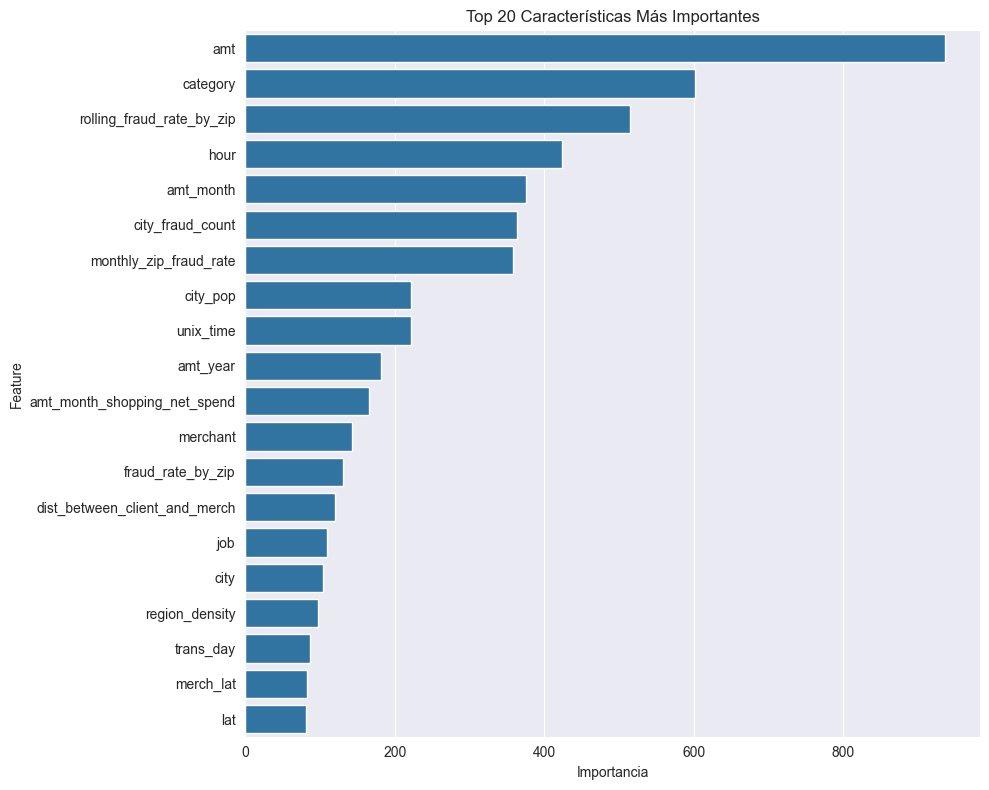

In [69]:
feature_imp = pd.Series(model_custom.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_imp.head(20), y=feature_imp.head(20).index)
plt.title("Top 20 Características Más Importantes")
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [70]:
# Guardar modelo
if not os.path.exists("models/custom"):
    os.makedirs("models/custom")

joblib.dump(model_custom, "models/custom/custom_model.pkl")

['models/custom/custom_model.pkl']